In [2]:
# ===============================
# Environment Setup
# ===============================
USE_COLAB = True

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_ROOT = "/content/drive/MyDrive/real-and-ai-generated-synthetic-images"
else:
    PROJECT_ROOT = os.path.abspath(".")

print("PROJECT_ROOT:", PROJECT_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PROJECT_ROOT: /content/drive/MyDrive/real-and-ai-generated-synthetic-images


In [3]:
!pip install -q kagglehub

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [6]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, RandomAffine, ColorJitter
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from argparse import ArgumentParser
from PIL import Image
import os
import shutil
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.datasets.folder import default_loader

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # --- Convolution blocks ---
        self.conv1 = self.make_block(3, 16)    # 32x32 → 16x16
        self.conv2 = self.make_block(16, 32)   # 16x16 → 8x8
        self.conv3 = self.make_block(32, 64)   # 8x8   → 4x4

        # --- Fully connected layers ---
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(64 * 4 * 4, 512),
            nn.LeakyReLU()
        )
        self.fc2 = nn.Linear(512, num_classes)

    def make_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [8]:
class ImagePathDataset(Dataset):
    '''
    Split train into val and train with same class set
    '''
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = default_loader(self.paths[idx])
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

In [9]:
def save_checkpoint(model, optimizer, epoch, accuracy, path):
    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'accuracy': accuracy
    }
    torch.save(checkpoint, path)
    print(f"Saved checkpoint: {path} (epoch {epoch+1}, acc={accuracy:.4f})")
# load the check point os the best model

def load_checkpoint(model, path='trained_models'):
    checkpoint_file = os.path.join(path, "best_model.pth")
    if os.path.exists(checkpoint_file):
        checkpoint = torch.load(checkpoint_file, map_location=device)
        model.load_state_dict(checkpoint["model"])
        print(f"Loaded checkpoint from {checkpoint_file}")
    else:
        print(f"No checkpoint found at {checkpoint_file}. Starting with random weights.")
    return model



In [10]:
# check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
train_dir = f'{path}/train'
test_dir = f'{path}/test'
ckpt_dir = f'{PROJECT_ROOT}/trained_models'
os.makedirs(ckpt_dir, exist_ok=True)

# Transform & Dataset
image_size = 32
batch_size = 64

# Data Augumentation
transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])
transform_train = transforms.Compose([
    RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.85, 1.15), shear=5,  fill=0),
    Resize((image_size, image_size)),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])
full_train_dataset = datasets.ImageFolder(root=train_dir)
indices = list(range(len(full_train_dataset)))
train_idx, val_idx = train_test_split(
    indices, test_size=0.2,
    stratify=[full_train_dataset.samples[i][1] for i in indices],
    random_state=42
)


# train_dataset = Subset(datasets.ImageFolder(root=train_dir, transform=transform_train), train_idx) # withou augumentation
train_dataset = Subset(datasets.ImageFolder(root=train_dir, transform=transform_test), train_idx) # without augumetation
val_dataset = Subset(datasets.ImageFolder(root=train_dir, transform=transform_test), val_idx)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

print(f"Total train images: {len(full_train_dataset)}")
print(f"Total test images: {len(test_dataset)}")
print(f"Train split: {len(train_dataset)}")
print(f"Validation split: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
class_names = full_train_dataset.classes


Using device: cuda
Total train images: 100000
Total test images: 20000
Train split: 80000
Validation split: 20000


In [11]:
model = SimpleCNN(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# TensorBoard
log_dir = f'{PROJECT_ROOT}/runs/cifake_cnn'
if os.path.isdir(log_dir):
    shutil.rmtree(log_dir)
writer = SummaryWriter(log_dir)

# Resume from checkpoint if exists
best_model_path = os.path.join(ckpt_dir, "best_model.pth")
start_epoch = 0
best_accuracy = 0.0

if os.path.exists(best_model_path):
    print(f"Found checkpoint at {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch'] + 1
    best_accuracy = checkpoint['accuracy']
    print(f"Resumed from epoch {start_epoch}, Best Acc={best_accuracy:.4f}")


In [12]:

num_epochs = 10

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Tính train loss và accuracy
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({"loss": loss.item()})

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total

    print(f"Epoch {epoch+1} — Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
    writer.add_scalar("TRAIN/Loss", epoch_train_loss, epoch)
    writer.add_scalar("TRAIN/Accuracy", epoch_train_acc, epoch)

    # --- Validation ---
    model.eval()
    val_preds, val_labels = [], []
    val_loss = 0.0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_total += labels.size(0)
            preds = torch.argmax(outputs, 1).cpu()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu())

    val_loss /= val_total
    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1} — Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    writer.add_scalar("VAL/Loss", val_loss, epoch)
    writer.add_scalar("VAL/Accuracy", val_acc, epoch)

    # if epoch % 5 == 0:
    #     cm = confusion_matrix(val_labels, val_preds)
    #     plot_confusion_matrix(writer, cm, class_names, epoch)

    # --- Save checkpoints ---
    last_ckpt_path = os.path.join(ckpt_dir, "last_model.pth")
    save_checkpoint(model, optimizer, epoch, val_acc, last_ckpt_path)

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        save_checkpoint(model, optimizer, epoch, val_acc, best_model_path)


Epoch [1/10]: 100%|██████████| 1250/1250 [00:31<00:00, 39.51it/s, loss=0.311]

Epoch 1 — Train Loss: 0.3520, Train Acc: 0.8443


Epoch 1 — Val Loss: 0.3504, Val Acc: 0.8459
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 1, acc=0.8459)
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/best_model.pth (epoch 1, acc=0.8459)


Epoch [2/10]: 100%|██████████| 1250/1250 [00:29<00:00, 42.18it/s, loss=0.308]


Epoch 2 — Train Loss: 0.2507, Train Acc: 0.8975
Epoch 2 — Val Loss: 0.2021, Val Acc: 0.9216
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 2, acc=0.9216)
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/best_model.pth (epoch 2, acc=0.9216)


Epoch [3/10]: 100%|██████████| 1250/1250 [00:33<00:00, 37.04it/s, loss=0.425]


Epoch 3 — Train Loss: 0.2202, Train Acc: 0.9126
Epoch 3 — Val Loss: 0.3167, Val Acc: 0.8700
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 3, acc=0.8700)


Epoch [4/10]: 100%|██████████| 1250/1250 [00:36<00:00, 34.70it/s, loss=0.231]

Epoch 4 — Train Loss: 0.2028, Train Acc: 0.9193


Epoch 4 — Val Loss: 0.1670, Val Acc: 0.9374
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 4, acc=0.9374)
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/best_model.pth (epoch 4, acc=0.9374)


Epoch [5/10]: 100%|██████████| 1250/1250 [00:29<00:00, 42.59it/s, loss=0.209]


Epoch 5 — Train Loss: 0.1902, Train Acc: 0.9245
Epoch 5 — Val Loss: 0.1831, Val Acc: 0.9281
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 5, acc=0.9281)


Epoch [6/10]: 100%|██████████| 1250/1250 [00:29<00:00, 42.10it/s, loss=0.16]

Epoch 6 — Train Loss: 0.1813, Train Acc: 0.9287


Epoch 6 — Val Loss: 0.1556, Val Acc: 0.9401
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 6, acc=0.9401)
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/best_model.pth (epoch 6, acc=0.9401)


Epoch [7/10]: 100%|██████████| 1250/1250 [00:29<00:00, 41.86it/s, loss=0.198]

Epoch 7 — Train Loss: 0.1750, Train Acc: 0.9305


Epoch 7 — Val Loss: 0.2318, Val Acc: 0.9099
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 7, acc=0.9099)


Epoch [8/10]: 100%|██████████| 1250/1250 [00:29<00:00, 42.39it/s, loss=0.0904]


Epoch 8 — Train Loss: 0.1691, Train Acc: 0.9338
Epoch 8 — Val Loss: 0.1572, Val Acc: 0.9416
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 8, acc=0.9416)
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/best_model.pth (epoch 8, acc=0.9416)


Epoch [9/10]: 100%|██████████| 1250/1250 [00:30<00:00, 40.53it/s, loss=0.197]


Epoch 9 — Train Loss: 0.1639, Train Acc: 0.9358
Epoch 9 — Val Loss: 0.1928, Val Acc: 0.9229
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 9, acc=0.9229)


Epoch [10/10]: 100%|██████████| 1250/1250 [00:29<00:00, 42.22it/s, loss=0.219]


Epoch 10 — Train Loss: 0.1614, Train Acc: 0.9368
Epoch 10 — Val Loss: 0.1459, Val Acc: 0.9456
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/last_model.pth (epoch 10, acc=0.9456)
Saved checkpoint: /content/drive/MyDrive/real-and-ai-generated-synthetic-images/trained_models/best_model.pth (epoch 10, acc=0.9456)


In [13]:
# --- Load Trained Model ---
model = SimpleCNN(num_classes=2).to(device)
ckpt_path = f'{ckpt_dir}/best_model.pth'

checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

# --- Inference ---
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# --- Metrics ---
acc = accuracy_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

print("\nTest Accuracy: {:.4f}".format(acc))
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)



Test Accuracy: 0.9399

Confusion Matrix:
 [[9308  692]
 [ 509 9491]]

Classification Report:
               precision    recall  f1-score   support

        FAKE     0.9482    0.9308    0.9394     10000
        REAL     0.9320    0.9491    0.9405     10000

    accuracy                         0.9399     20000
   macro avg     0.9401    0.9400    0.9399     20000
weighted avg     0.9401    0.9399    0.9399     20000



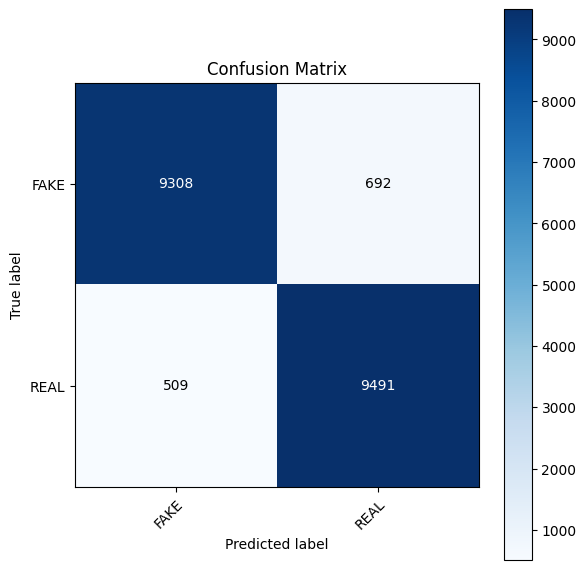

In [14]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(class_names)),
       yticks=np.arange(len(class_names)),
       xticklabels=class_names, yticklabels=class_names,
       ylabel='True label',
       xlabel='Predicted label',
       title='Confusion Matrix')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

In [16]:
from torchsummary import summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         LeakyReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
         LeakyReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          18,496
      BatchNorm2d-10             [-1, 64, 8, 8]             128
        LeakyReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Dropout-13                 [-1, 1024]               0
           Linear-14                  [